#  Asymmetric Mach Reflection

## MR

In [18]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import intersection 
from scipy import interpolate as scipolate
gamma=1.4
nonstd = 'True'
def phi(theta1, M):
    out = optimize.fsolve(lambda x: fun(x,M,theta1),0.01)
    out = np.append(out, optimize.fsolve(lambda x: fun(x,M,theta1),np.pi/2))
    return out
def theta(x,M):
    out = 2*(1/np.tan(x))*(M**2*(np.sin(x))**2-1)/(M**2*(gamma+np.cos(2*x))+2)
    out = np.arctan(out)
    return out
def fun(x,M,theta1):
    f=np.tan(theta1)-2*(1/np.tan(x))*(M**2*(np.sin(x))**2-1)/(M**2*(gamma+np.cos(2*x))+2)
    return f
def fun2(x,M):
    theta1=np.arctan(2*(1/np.tan(x))*(M**2*(np.sin(x))**2-1)/(M**2*(gamma+np.cos(2*x))+2))
    return theta1
def thetaMax(M):
    phi=optimize.fmin(lambda x: -fun2(x,M),0.1)
    theta1=fun2(phi,M)
    return theta1

class state(object):
  def __init__(self,p=100000,M=1.5,T=300,R=287,phi=0,gamma=gamma):
    self.p=p
    self.M=M
    self.T=T
    self.gamma=gamma
    self.phi=phi
    self.R=R
    self.rho=self.p/(self.R*self.T)
    self.u=self.M*np.sqrt(self.gamma*self.R*self.T)
    
def oblique(state0,theta1=10*np.pi/180,weak='True'):
  #theta=theta
  p=phi(theta1,state0.M)
  tmax=thetaMax(state0.M)
  print("Theta max :",tmax*180/np.pi)
  if tmax<theta1:
        print("Shock detached")
  else:
    if weak=='True':
      ph=p[0]
    else:
      ph=p[1]
    M1=np.sqrt((1+(state0.gamma-1)*0.5*(state0.M*np.sin(ph))**2)/(state0.gamma*(state0.M*np.sin(ph))**2-(state0.gamma-1)*0.5))/(np.sin(ph-theta1))
    p2=state0.p*(1+2*state0.gamma*((state0.M*np.sin(ph))**2-1)/(1+state0.gamma))
    T2=state0.T*(p2/state0.p)*(2+(state0.gamma-1)*(state0.M*np.sin(ph))**2)/((1+state0.gamma)*(state0.M*np.sin(ph))**2)
    state1=state(M=M1,p=p2,T=T2)
    state1.phi = ph
    state1.theta= theta1
    return state1

def ST(state0,theta1,nonstd=nonstd):
  state1=oblique(state0,theta1=theta1)
  if theta1<thetaMax(state1.M):
        print("This case is a Regular reflection")
        print("Solving using 2 shock theory . . .")
        state2=oblique(state1,theta1=theta1)
        return state1,state2
  else:
    print("This case is a Mach reflection")
    print("Solving for the Standard solution using 3 shock theory...")
    phi = ThreeST(state0,state1,theta1)
    phi2 = phi[0]
    phi3 = phi[1]
    theta2 = theta(phi2,state1.M)
    print(theta2*180/np.pi)
    theta3 = theta(phi3,state0.M)
    state3 = oblique(state0,theta1=theta3,nonstd=nonstd)
    state3.phi = phi3
    state3.theta = theta3
    state2 = oblique(state1,theta1=theta2)
    state2.phi = phi2
    state2.theta =theta2
    return state1,state2,state3

def ThreeST(state0,state1,theta1,nonstd=nonstd):
    p = np.array([[]])
    p = np.append(p,state0.M)  # M0
    p = np.append(p,state1.M)  # M1
    p = np.append(p,theta1)  # theta
    p = np.append(p,state1.p/state0.p) # p1/p0
    return optimize.fsolve(lambda x: fun3(x,p,nonstd=nonstd),100*np.array([0.01,0.01]))
    
def fun3(x,p,gamma = gamma,nonstd='False'):
    """
    x[0] - phi2
    x[1] - phi3
    """
    f=np.array([])
    f=np.append(f,(1+2*(p[1]**2*np.sin(x[0])**2-1)*gamma/(gamma+1))*p[3]-(1+2*(p[0]**2*np.sin(x[1])**2-1)*gamma/(gamma+1)))
    if nonstd=='True':
        ## NON STANDARD SOLUTION
        f=np.append(f,p[2]+theta(x[0],p[1])-theta(x[1],p[0]))
    else :
        f=np.append(f,p[2]+theta(x[0],p[1])-theta(x[1],p[0]))
    return f
    
    
def polar(M0,both = 'True',type ='p', positive='True',gamma=gamma):
    tmax = thetaMax(M0)
    print("ThetaMax:", tmax*180/np.pi)
    theta = np.linspace(0,tmax,100)
    if type == 'p':
      pWeak = np.asarray([pRatio(k,M0) for k in theta])
      pStrong = np.asarray([pRatio(k,M0,weak = 'False') for k in theta])
    elif type == 'M':
      pWeak = np.asarray([Mj(k,M0) for k in theta])
      pStrong = np.asarray([Mj(k,M0,weak = 'False') for k in theta])
    elif type == 'rho':
      pWeak = np.asarray([rho(k,M0) for k in theta])
      pStrong = np.asarray([rho(k,M0,weak = 'False') for k in theta])
    elif type == 'T':
      pWeak = np.asarray([pRatio(k,M0)/rho(k,M0) for k in theta])
      pStrong = np.asarray([pRatio(k,M0,weak = 'False')/rho(k,M0,weak = 'False') for k in theta])  
    theta = np.append(theta,np.flipud(theta))
    p = np.append(pWeak,np.flipud(pStrong))
    if both =='True':
       p = np.append(p,np.flipud(p))
       theta = np.append(theta,np.flipud(-theta))
    return theta, p

def plot(theta,p,label,name='output1'):
    for k,j,m in zip(theta,p,label):
        plt.plot(theta[k]*180/np.pi,p[j],label=label[m],linewidth=1)
    #for k,j,m in zip(ts,ps,ls):
    #    plt.plot(ts[k]*180/np.pi,ps[j],marker='o',label=ls[m],ms=0.5)
    plt.grid()
    plt.legend(loc='best')
    plt.xlabel('theta')
    plt.savefig("%s.eps"%name, format='eps', dpi=1000)
    plt.show()
  
   
def Mj(x,M,gamma =gamma, weak = 'True'):
    y = phi(x,M)
    if weak =='True':
        z = y[0]
    else : 
        z = y[1]
    Mj=np.sqrt((1+(gamma-1)*0.5*(M*np.sin(z))**2)/(gamma*(M*np.sin(z))**2-(gamma-1)*0.5))/(np.sin(z-x))
    return Mj

def rho(x,M,gamma =gamma, weak = 'True'):
    y = phi(x,M)
    if weak =='True':
        z = y[0]
    else : 
        z = y[1]
    rho=((1+gamma)*(M*np.sin(z))**2)/(2+(gamma-1)*(M*np.sin(z))**2)
    return rho    
    
def pRatio(x,M,gamma =gamma, weak = 'True'):
    y = phi(x,M)
    if weak =='True':
        z = y[0]
    else : 
        z = y[1]
    p = 1+2*gamma*((M*np.sin(z))**2-1)/(1+gamma)
    return p

def pRatioMax(M):
    return optimize.fmin(lambda x: -pRatio(x,M,gamma=gamma),0.1)

def thetaSonic(M):
    type = 'M'
    #s0=state(M=M,p=100000, T = 300)
    theta0, M0 = polar(M,type =type)
    f=scipolate.interp1d(M0[:100], theta0[:100])
    return f(1)

def AMR(t1 =38.2,t2 = 38.2 ,name= 'output'):

    t1 = t1*np.pi/180
    t2 = t2*np.pi/180
    M0 = 4.96
    type='p'
    theta0, p0 = polar(M0,type =type)
    M1u=Mj(t1,M0)
    M1l=Mj(t2,M0)
    theta1, p1 = polar(M0)
    theta2u, p2u = polar(M1u)
    theta2l, p2l = polar(M1l)
    p1u_= np.interp(t1,theta1[:100],p1[:100])
    p1l_= np.interp(t2,theta1[:100],p1[:100])

    theta_={1:theta1,
            2:theta2u+t1,
            3:theta2l-t2
           }
    p={1:p1,
       2: p2u*p1u_,
       3: p2l*p1l_
      }
    label = {1: 'incident',
             2: 'r - upper',
             3: 'r - lower'
            }

    #y1 = p2u*p1u_
    plot(theta_,p,label,name=name)
    #x,y=intersection.intersection(theta0+t1*np.pi/180,y1)
    #print("Solutions:")
    #print(x[0]*180/np.pi, "degrees :", y[0])    

Optimization terminated successfully.
         Current function value: -0.716433
         Iterations: 20
         Function evaluations: 40
ThetaMax: [41.04858104]
Optimization terminated successfully.
         Current function value: -0.716433
         Iterations: 20
         Function evaluations: 40
ThetaMax: [41.04858104]
Optimization terminated successfully.
         Current function value: -0.633298
         Iterations: 20
         Function evaluations: 40
ThetaMax: [36.28529833]
Optimization terminated successfully.
         Current function value: -0.300261
         Iterations: 20
         Function evaluations: 40
ThetaMax: [17.20366384]


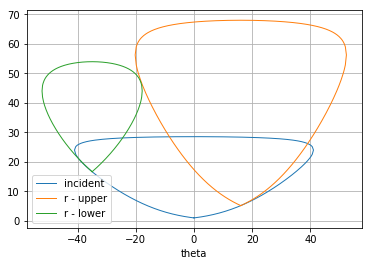

In [30]:
AMR(t2 =35,t1 =16.08, name= 'i')

Optimization terminated successfully.
         Current function value: -0.304154
         Iterations: 20
         Function evaluations: 40
ThetaMax: [17.42671395]
Optimization terminated successfully.
         Current function value: -0.304154
         Iterations: 20
         Function evaluations: 40
ThetaMax: [17.42671395]
Optimization terminated successfully.
         Current function value: -0.060815
         Iterations: 21
         Function evaluations: 42
ThetaMax: [3.48441671]
Optimization terminated successfully.
         Current function value: -0.060815
         Iterations: 21
         Function evaluations: 42
ThetaMax: [3.48441671]
Optimization terminated successfully.
         Current function value: -0.304154
         Iterations: 20
         Function evaluations: 40
ThetaMax: [17.42671395]
Optimization terminated successfully.
         Current function value: -0.060815
         Iterations: 21
         Function evaluations: 42
ThetaMax: [3.48441671]
Optimization terminated s

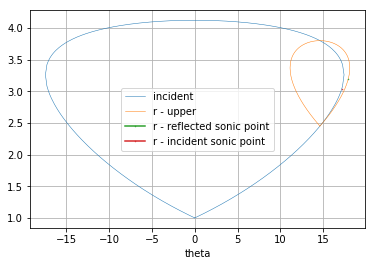

Solutions:
-0.0 degrees : 3.622916658639934
-0.0 degrees : 3.0449288828217873


In [140]:
Ms = 1.47
tc = 38.2*np.pi/180
phi1 = np.pi/2-tc
M0 = Ms/np.cos(tc)
tsonic0 = thetaSonic(M0)*180/np.pi

type='p'
theta0, p0 = polar(M0,type =type)
t1 =theta(phi1,M0)*180/np.pi
t2 =t1

M1u=Mj(t1*np.pi/180,M0)
tsonicR1 = t1+thetaSonic(M1u)*180/np.pi
M1l=Mj(t2*np.pi/180,M0)
tsonicR2 = t2+thetaSonic(M1l)*180/np.pi

theta1, p1 = polar(M0)
theta2u, p2u = polar(M1u)
theta2l, p2l = polar(M1l)

p1u_= np.interp(t1*np.pi/180,theta1[:100],p1[:100])
p1l_=np.interp(t2*np.pi/180,theta1[:100],p1[:100])

# sonic points
tsonic0 = thetaSonic(M0)
tsonicR1 = theta(phi1,M0)+thetaSonic(M1u)
p1usonic= np.interp(tsonicR1,theta1[:95],p2u[:95]*p1u_)
p1lsonic=np.interp(tsonicR2*np.pi/180,theta1[:110],p2l[:110]*p1l_)
p0sonic= np.interp(tsonic0,theta1[:100],p1[:100])

theta={1:theta1,
       2:theta2u+t1*np.pi/180
       #3:theta2l-t2*np.pi/180
      }
ts={1:tsonicR1,
    #2:tsonicR2*np.pi/180
   2:tsonic0
   } 
p    ={1:p1,
       2: p2u*p1u_
      # 3:p2l*p1l_
      }
ps={1:p1usonic,
    #2:p1lsonic
    2:p0sonic
   }
label = {1: 'incident',
         2: 'r - upper'
        # 3: 'r - lower',
         #4: 'r - upper sonic point',
         #5: 'r - lower sonic point',
         #6: 'r - incident sonic point'
        }
ls={#1: 'r - upper sonic point',
         1: 'r - reflected sonic point',
         2: 'r - incident sonic point'
   }


y1 = p2u*p1u_
y2 = p2l*p1l_
plot(theta,p,label,ts,ps,ls,name='sym')

x,y=intersection.intersection(theta0+t1*np.pi/180,y1,theta0-t2*np.pi/180,y2)
print("Solutions:")
print(x[0]*180/np.pi, "degrees :", y[0])
print(x[1]*180/np.pi, "degrees :", y[1])